# Carga del archivo, preparar los datos

In [1]:
# Importar modulos
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.stats.proportion import proportions_ztest

In [2]:
# Cargar el archivo
df = pd.read_csv('/datasets/logs_exp_us.csv', sep='\t')

# Verificar tipos de datos
df.info()
print('\nExtracto del DF:\n',df.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB

Extracto del DF:
                  EventName         DeviceIDHash  EventTimestamp  ExpId
187726  OffersScreenAppear  8995413199120916688      1565083683    247
11978     MainScreenAppear  4050125088571572193      1564651221    247
32386     MainScreenAppear  6237578769080508866      1564681682    247
5530      MainScreenAppear  1469821186825308546      1564637407    246
20691     CartScreenAppear  4980045449118619005      1564665017    247


In [3]:
# Renombrar columnas snake_case
df.columns=['event_name','device_id','timestamp','exp_id']

# Cambiar EventTimestamp a tipo datetime
df['timestamp'] = pd.to_datetime(df['timestamp'],unit='s')
print('Muestra del DF:')
print(df.sample(5))
# Verificar si hay valores nulos
print('\nValores nulos:\n',df.isna().sum())

# Verificar si hay valores duplicados
print('\nValores duplicados:',df.duplicated().sum())

Muestra del DF:
              event_name            device_id           timestamp  exp_id
116613  MainScreenAppear  2685586130308713333 2019-08-04 09:29:03     246
124446  MainScreenAppear   316545280028060457 2019-08-04 12:48:52     247
144592  MainScreenAppear  5510275687753597328 2019-08-05 06:05:45     247
243042  MainScreenAppear   443561935427724017 2019-08-07 19:56:04     246
123787  MainScreenAppear  5057682141255042699 2019-08-04 12:33:58     246

Valores nulos:
 event_name    0
device_id     0
timestamp     0
exp_id        0
dtype: int64

Valores duplicados: 413


In [4]:
# Eliminar duplicados
df = df.drop_duplicates().reset_index(drop=True)
# Agregar columna fecha
df['date'] = df['timestamp'].dt.date

print(df.head())
print('\nValores duplicados:',df.duplicated().sum())

                event_name            device_id           timestamp  exp_id  \
0         MainScreenAppear  4575588528974610257 2019-07-25 04:43:36     246   
1         MainScreenAppear  7416695313311560658 2019-07-25 11:11:42     246   
2  PaymentScreenSuccessful  3518123091307005509 2019-07-25 11:28:47     248   
3         CartScreenAppear  3518123091307005509 2019-07-25 11:28:47     248   
4  PaymentScreenSuccessful  6217807653094995999 2019-07-25 11:48:42     248   

         date  
0  2019-07-25  
1  2019-07-25  
2  2019-07-25  
3  2019-07-25  
4  2019-07-25  

Valores duplicados: 0


# Estudiar y comprobar los datos

### ¿Cuántos eventos hay en los registros?

In [5]:
print('Total de eventos:', len(df))

Total de eventos: 243713


### ¿Cuántos usuarios hay en los registros?

In [6]:
print('Total de usuarios:', df['device_id'].nunique())

Total de usuarios: 7551


### ¿Cuál es el promedio de eventos por usuario?

In [7]:
print(f"Promedio de eventos por usuario: {len(df)/df['device_id'].nunique():.2f}")

Promedio de eventos por usuario: 32.28


### ¿Qué periodo de tiempo cubren los datos?

In [8]:
min_date = df['date'].min()
max_date = df['date'].max()
print(f'Periodo de {min_date} a {max_date}')

Periodo de 2019-07-25 a 2019-08-07


### Histograma

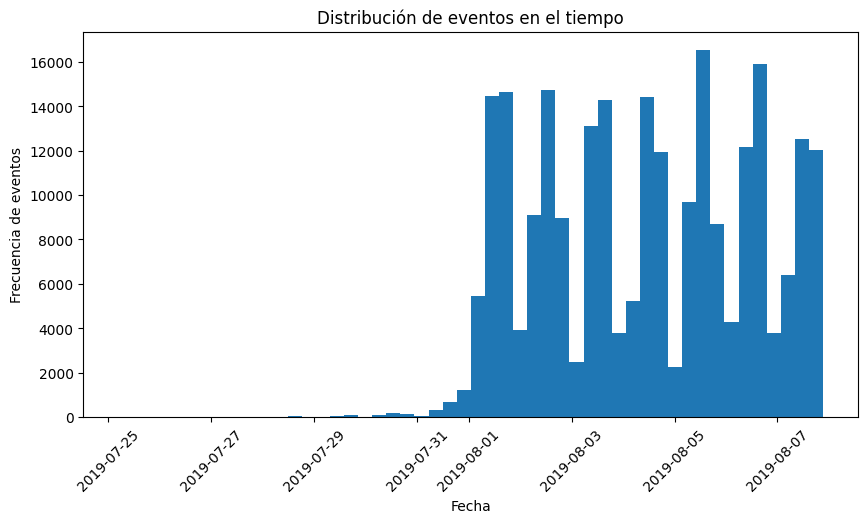

In [9]:
plt.figure(figsize=(10,5))
plt.hist(df['timestamp'], bins=50)
plt.title('Distribución de eventos en el tiempo')
plt.xticks(rotation=45)
plt.xlabel('Fecha')
plt.ylabel('Frecuencia de eventos')
plt.show()

### ¿Puedes tener seguridad de que tienes datos igualmente completos para todo el periodo?

In [10]:
events_by_date = df.groupby('date').size()
print("\nEventos por día:")
print(events_by_date)


Eventos por día:
date
2019-07-25        9
2019-07-26       31
2019-07-27       55
2019-07-28      105
2019-07-29      184
2019-07-30      412
2019-07-31     2030
2019-08-01    36141
2019-08-02    35554
2019-08-03    33282
2019-08-04    32968
2019-08-05    36058
2019-08-06    35788
2019-08-07    31096
dtype: int64


Se observan pocos datos en julio y un aumento considerable en agosto. Los datos anteriores al primero de agosto podrían sesgar el panorama general.

### ¿Qué periodo representan realmente los datos?

Los datos a partir del 01-agosto-2019 es el periodo representativo, se filtrará para trabajar solo con estos.

### ¿Perdiste muchos eventos y usuarios al excluir los datos más antiguos?

In [11]:
# Filtrar 01-08-2019
cutoff_date = pd.to_datetime('2019-08-01')
df_filtrado = df[df['date'] >= cutoff_date]

# Calcular perdidas
users_original = df['device_id'].nunique()
users_filtered = df_filtrado['device_id'].nunique()
users_lost = users_original - users_filtered
events_original = len(df)
events_filtered = len(df_filtrado)
lost_events = events_original - events_filtered


print(f'Usuarios del df original: {users_original}')
print(f'Usuarios del df filtrado: {users_filtered}')
print(f'Usuarios perdidos: {users_lost} usuarios o {users_lost*100/users_original:.2f}% perdido')

print(f'\nEventos del df original: {events_original}')
print(f'Usuarios del df filtrado: {events_filtered}')
print(f'Usuarios perdidos: {lost_events} eventos o {lost_events*100/events_original:.2f}% perdido')

Usuarios del df original: 7551
Usuarios del df filtrado: 7534
Usuarios perdidos: 17 usuarios o 0.23% perdido

Eventos del df original: 243713
Usuarios del df filtrado: 240887
Usuarios perdidos: 2826 eventos o 1.16% perdido


La pérdida es mínima, solo el 0.23% de usuarios y 1.16% de eventos quedaron fuera tras el filtrado.

### Usuarios en los 3 grupos experimentales

In [12]:
# Verificar presencia de usuarios en los 3 grupos
groups_check = df_filtrado['exp_id'].value_counts()
print("\nUsuarios por grupo en df filtrado:")
print(groups_check)


Usuarios por grupo en df filtrado:
248    84563
246    79302
247    77022
Name: exp_id, dtype: int64


# Estudiar el embudo de eventos

### Frecuencia de los eventos:

In [13]:
events_check = df_filtrado['event_name'].value_counts().sort_values(ascending=False)
print('Frecuencia de los eventos en los registros:\n')
print(events_check)

Frecuencia de los eventos en los registros:

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64


### Cantidad de usuarios que realizaron cada una de estas acciones

In [14]:
users_per_event = df_filtrado.groupby('event_name')['device_id'].nunique().sort_values(ascending=False)
users_per_event.name='users'
print('Usuarios que realizan cada acción:')
print(users_per_event)

Usuarios que realizan cada acción:
event_name
MainScreenAppear           7419
OffersScreenAppear         4593
CartScreenAppear           3734
PaymentScreenSuccessful    3539
Tutorial                    840
Name: users, dtype: int64


### Proporción de usuarios que realizaron la acción al menos una vez

In [15]:
users_per_event_pct = (users_per_event / df_filtrado['device_id'].nunique() * 100).round(2)
users_per_event_pct = users_per_event_pct.reset_index()
users_per_event_pct.columns = ['events','pct(%)']
print('Proporción de usuarios por acción:')
print(users_per_event_pct)

Proporción de usuarios por acción:
                    events  pct(%)
0         MainScreenAppear   98.47
1       OffersScreenAppear   60.96
2         CartScreenAppear   49.56
3  PaymentScreenSuccessful   46.97
4                 Tutorial   11.15


### ¿En qué orden crees que ocurrieron las acciones? ¿Todas son parte de una sola secuencia?

El orden de los eventos más lógico sería:

* MainScreenAppear -> OffersScreenAppear -> CartScreenAppear -> PaymentScreenSuccessful
* El Tutorial no es necesario tenerlo en cuenta para calcular el embudo.

### Embudo de eventos

In [16]:
# Crear el embudo
funnel_order = ['MainScreenAppear', 'OffersScreenAppear','CartScreenAppear','PaymentScreenSuccessful']
funnel_users = users_per_event[funnel_order]
funnel_df = pd.DataFrame(funnel_users).reset_index()
funnel_df.columns = ['event', 'users']

# Total de usuarios
total_users = funnel_df.iloc[0,1]

# Conversion total
funnel_df['conversion_total(%)'] = (funnel_df['users']/total_users*100).round(2)

# Conversion paso a paso
funnel_df['paso_anterior'] = funnel_df['users'].shift(1)
funnel_df['conversion_paso(%)'] = (funnel_df['users']/funnel_df['paso_anterior']*100).fillna(100).round(2)

print("\nEmbudo con Conversiones:")
print(funnel_df[['event', 'users', 'conversion_total(%)','conversion_paso(%)']])


Embudo con Conversiones:
                     event  users  conversion_total(%)  conversion_paso(%)
0         MainScreenAppear   7419               100.00              100.00
1       OffersScreenAppear   4593                61.91               61.91
2         CartScreenAppear   3734                50.33               81.30
3  PaymentScreenSuccessful   3539                47.70               94.78


### ¿En qué etapa pierdes más usuarios?

La etapa en la cual se pierden más usuarios es entre la Pantalla Principal (MainScreenAppear) y la Pantalla de Ofertas (OffersScreenAppear). Aproximadamente 39% de los usuarios se pierden aquí, tiene la conversión paso a paso más baja.

### ¿Qué porcentaje de usuarios hace todo el viaje desde su primer evento hasta el pago?

Alrededor del 47% de los usuarios completan el recorrido hasta la pantalla de Pago desde la visita en la Pantalla Principal.

# Resultados del experimento

In [17]:
# Usuarios de cada Grupo
pivot = df_filtrado.pivot_table(index='event_name', columns='exp_id', values='device_id', aggfunc='nunique')
pivot = pivot.loc[funnel_order].reset_index()
print(pivot)

exp_id               event_name   246   247   248
0              MainScreenAppear  2450  2476  2493
1            OffersScreenAppear  1542  1520  1531
2              CartScreenAppear  1266  1238  1230
3       PaymentScreenSuccessful  1200  1158  1181


### ¿Cuántos usuarios hay en cada grupo?

In [18]:
# Total usuarios por grupo
user_per_group = df_filtrado.groupby('exp_id')['device_id'].nunique()
print(user_per_group)

exp_id
246    2484
247    2513
248    2537
Name: device_id, dtype: int64


In [19]:
# Separar grupos
group_246 = df_filtrado[df_filtrado['exp_id'] == 246] # Control A1
group_247 = df_filtrado[df_filtrado['exp_id'] == 247] # Control A2
group_248 = df_filtrado[df_filtrado['exp_id'] == 248] # B

# Test de Hipótesis
def check_hypo(group1_df, group2_df, event, alpha):
    
    #Calcular exitos
    sucess1 = group1_df[group1_df['event_name'] == event]['device_id'].nunique()
    sucess2 = group2_df[group2_df['event_name'] == event]['device_id'].nunique()

    #Numero de observaciones
    nob1 = group1_df['device_id'].nunique()
    nob2 = group2_df['device_id'].nunique()

    #Z-test
    stat, p_value = proportions_ztest([sucess1,sucess2],[nob1,nob2])

    print(f'--- {event} ---')
    print(f"Grupos {group1_df['exp_id'].unique()} vs {group2_df['exp_id'].unique()}")
    print(f'Valor p: {p_value:.4f}')

    if p_value < alpha:
        print('Rechazamos H0: Hay Diferencia significativa')
    else:
        print('No rechazamos H0: No hay diferencia significativa (Son similares)')
    print('-' * 30)

### ¿Puedes confirmar que los grupos se dividieron correctamente?

In [20]:
# Test A/A grupos 246 y 247 iguales, alpha=0.05
events_to_test = ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']
for event in events_to_test:
    check_hypo(group_246,group_247,event,0.05)

--- MainScreenAppear ---
Grupos [246] vs [247]
Valor p: 0.7571
No rechazamos H0: No hay diferencia significativa (Son similares)
------------------------------
--- OffersScreenAppear ---
Grupos [246] vs [247]
Valor p: 0.2481
No rechazamos H0: No hay diferencia significativa (Son similares)
------------------------------
--- CartScreenAppear ---
Grupos [246] vs [247]
Valor p: 0.2288
No rechazamos H0: No hay diferencia significativa (Son similares)
------------------------------
--- PaymentScreenSuccessful ---
Grupos [246] vs [247]
Valor p: 0.1146
No rechazamos H0: No hay diferencia significativa (Son similares)
------------------------------


En las 4 comparaciones de la Prueba A/A se rechaza la hipótesis nula, no se encontraron diferencias estadísticamente significativas entre los 2 grupos control. **Los grupos se dividieron correctamente**.

### Comparación para el grupo con fuentes alteradas.

In [21]:
#Grupo combinado
group_control_combined = pd.concat([df_filtrado[df_filtrado['exp_id']==246], 
                                    df_filtrado[df_filtrado['exp_id']==247]])
# Test A/B y combinado/B, alpha 0.05
for event in events_to_test:
    check_hypo(group_246,group_248,event,0.05)
    check_hypo(group_247,group_248,event,0.05)
    check_hypo(group_control_combined,group_248,event,0.05)

--- MainScreenAppear ---
Grupos [246] vs [248]
Valor p: 0.2950
No rechazamos H0: No hay diferencia significativa (Son similares)
------------------------------
--- MainScreenAppear ---
Grupos [247] vs [248]
Valor p: 0.4587
No rechazamos H0: No hay diferencia significativa (Son similares)
------------------------------
--- MainScreenAppear ---
Grupos [246 247] vs [248]
Valor p: 0.2942
No rechazamos H0: No hay diferencia significativa (Son similares)
------------------------------
--- OffersScreenAppear ---
Grupos [246] vs [248]
Valor p: 0.2084
No rechazamos H0: No hay diferencia significativa (Son similares)
------------------------------
--- OffersScreenAppear ---
Grupos [247] vs [248]
Valor p: 0.9198
No rechazamos H0: No hay diferencia significativa (Son similares)
------------------------------
--- OffersScreenAppear ---
Grupos [246 247] vs [248]
Valor p: 0.4343
No rechazamos H0: No hay diferencia significativa (Son similares)
------------------------------
--- CartScreenAppear ---
G

**Conclusiones:** No hay diferencias significativas entre el grupo control y el grupo de prueba. La implementación de una fuente nueva a toda la aplicación no afectó significativamente el comportamiento de los usuarios, el nuevo diseño no parece ser intimidante.

### Cambiando el nivel de significancia (Bonferroni)

In [22]:
# Corrección de Bonferroni
alpha = 0.05
n_tests = 16
bonferroni_alpha = alpha/n_tests

print('Nuevo nivel de significancia (Bonferroni):',bonferroni_alpha)
print('~'*50)

print('\nPrueba A/A')
print('~'*50)
for event in events_to_test:
    check_hypo(group_246,group_247,event,bonferroni_alpha)


print('\nPrueba A/B')
print('~'*50)
for event in events_to_test:
    check_hypo(group_246,group_248,event,bonferroni_alpha)
    check_hypo(group_247,group_248,event,bonferroni_alpha)
    check_hypo(group_control_combined,group_248,event,bonferroni_alpha)

Nuevo nivel de significancia (Bonferroni): 0.003125
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Prueba A/A
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
--- MainScreenAppear ---
Grupos [246] vs [247]
Valor p: 0.7571
No rechazamos H0: No hay diferencia significativa (Son similares)
------------------------------
--- OffersScreenAppear ---
Grupos [246] vs [247]
Valor p: 0.2481
No rechazamos H0: No hay diferencia significativa (Son similares)
------------------------------
--- CartScreenAppear ---
Grupos [246] vs [247]
Valor p: 0.2288
No rechazamos H0: No hay diferencia significativa (Son similares)
------------------------------
--- PaymentScreenSuccessful ---
Grupos [246] vs [247]
Valor p: 0.1146
No rechazamos H0: No hay diferencia significativa (Son similares)
------------------------------

Prueba A/B
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
--- MainScreenAppear ---
Grupos [246] vs [248]
Valor p: 0.2950
No rechazamos H0: No hay diferencia significativa (Son simi

**Conclusiones:** Se mantiene la misma conlcusión, no hay diferencias significativas entre el grupo control y el grupo de prueba. El cambio de las fuentes de la aplicación no tuvo un impacto estadísticamente significativo.
Con la corrección de Bonferroni, podemos afirmar con una confianza del **99.68%** que no hay diferencias significativas por el cambio de fuentes.